In [2]:
import gym
import numpy as np
from gym import spaces
from scipy.stats import norm
from scipy.special import kl_div
import matplotlib.pyplot as plt
import random

In [3]:
class GridWorld(gym.Env):
    def __init__(self, n):
        super(GridWorld, self).__init__()
        self.n = n  # Grid size
        self.action_space = spaces.Discrete(4)  # Up, Down, Left, Right
        self.observation_space = spaces.Tuple((spaces.Discrete(n), spaces.Discrete(n)))
        self.current_position = [0, 0]  # Starting at top-left corner

    def reset(self):
        self.current_position = [0, 0]
        return self.current_position

    def step(self, action):
        x, y = self.current_position

        # Update position based on action
        if action == 0:  # Up
            x = max(0, x - 1)
        elif action == 1:  # Down
            x = min(self.n - 1, x + 1)
        elif action == 2:  # Left
            y = max(0, y - 1)
        elif action == 3:  # Right
            y = min(self.n - 1, y + 1)

        self.current_position = [x, y]

        # Calculate reward
        reward = 0  # Default negative reward
        if (x, y) == (self.n - 1, self.n - 1):  # Goal cell
            reward = self.n
            done = True
        else:
            reward = np.random.choice([(abs((self.n - (x+1) + 1) - (y+1)) + 1), -(abs((self.n - (x+1) + 1) - (y+1)) + 1)], p=[0.5, 0.5])

        done = (x, y) == (self.n - 1, self.n - 1)  # Episode is done if we reach the goal cell

        return self.current_position, reward, done

    def render(self, mode='human'):
        grid = np.zeros((self.n, self.n), dtype=str)
        grid.fill('-')
        for x in range(self.n):
            for y in range(self.n):
                reward = np.random.choice([abs((self.n - (x+1) + 1) - (y+1)) + 1, -abs((self.n - (x+1) + 1) - (y+1)) + 1])
                if (x, y) == (self.current_position[0], self.current_position[1]):
                    cell_str = 'A'
                elif (x, y) == (self.n - 1, self.n - 1):
                    cell_str = 'G'
                else:
                    reward = abs((self.n - (x+1) + 1) - (y+1)) + 1
                    cell_str = f'{reward}'
                grid[x, y] = cell_str
        print(grid)

In [4]:
# Usage:
env = GridWorld(5)  # Create a 5x5 grid
obs = env.reset()
'''
done = False
while not done:
    action = env.action_space.sample()  # Random action
    obs, reward, done = env.step(action)
    env.render()
    print(f'Reward: {reward}')
'''

def kl_divergence(p, q):
        # Assuming p and q are scipy.stats.norm objects
        xs = np.linspace(-10, 10, 1000)
        p_pdf = p.pdf(xs)
        q_pdf = q.pdf(xs)
        
        # Adding a small constant to avoid divide by zero
        epsilon = 1e-10
        q_pdf += epsilon
        
        # Calculate the KL divergence
        kl_div = np.sum(p_pdf * np.log(p_pdf / q_pdf))
        
        return kl_div

In [5]:
class BayesianRLAgent:
    def __init__(self, action_space, gamma=0.99, epsilon=0.1):
        self.action_space = action_space
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate

        # Use Gaussian distribution parameters (mean, std) for Q-values
        self.q_values_mean = {}
        self.q_values_std = {}
        self.prior_mean = {}
        self.prior_std = {}

    def get_q_value_distribution(self, state, action):
        mean = self.q_values_mean.get((tuple(state), action), 0.0)
        std = self.q_values_std.get((tuple(state), action), 1.0)
        return mean, std

    def select_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return self.action_space.sample()  # Choose a random action
        else:
            means = np.array([self.get_q_value_distribution(state, a)[0] for a in range(self.action_space.n)])
            
            # Randomly choose among the actions that have the maximum mean Q-value
            max_mean_value = np.max(means)
            max_indices = np.where(means == max_mean_value)[0]
            return np.random.choice(max_indices)
        
    def update(self, state, action, reward, next_state):
        mean, std = self.get_q_value_distribution(state, action)
        
        # Compute the best expected future rewards, similar to Q-Learning
        best_next_q_value = max([self.get_q_value_distribution(next_state, a)[0] for a in range(self.action_space.n)])
        
        # Compute the TD target
        td_target = reward + self.gamma * best_next_q_value
        
        # Compute likelihood given new TD target, assuming Gaussian noise
        likelihood_mean = td_target
        likelihood_std = 1.0  # Assume some known noise level

        # Bayesian update (simplified, assuming Gaussian prior and likelihood)
        new_mean = (std**2 * likelihood_mean + likelihood_std**2 * mean) / (std**2 + likelihood_std**2)
        new_std = np.sqrt(1 / (1 / std**2 + 1 / likelihood_std**2))

        # Update mean and std for Q-value
        self.q_values_mean[(tuple(state), action)] = new_mean
        self.q_values_std[(tuple(state), action)] = new_std

    
    
    def compute_pac_bayes_bound(self, delta=0.05, m=1000):
        total_kl_divergence = 0.0
        num_state_actions = 0

        for (state, action), mean_value in self.q_values_mean.items():
            # For the sake of simplicity, let's assume the prior is a Gaussian with mean=0 and std=1
            prior_mean = 0.0
            prior_std = 1.0

            # Create norm objects for prior and posterior
            prior = norm(prior_mean, prior_std)
            posterior_mean = mean_value
            posterior_std = self.q_values_std.get((tuple(state), action), 1.0)
            posterior = norm(posterior_mean, posterior_std)

            # Calculate KL divergence using custom function
            kl_divergence_v = kl_divergence(prior, posterior)
            
            total_kl_divergence += kl_divergence_v
            num_state_actions += 1

            
            total_kl_divergence += kl_divergence_v
            num_state_actions += 1

        # Added debugging print statements

        avg_kl_divergence = total_kl_divergence / max(num_state_actions, 1)
        pac_bayes_bound = (avg_kl_divergence + np.log(m / delta)) / m
        return pac_bayes_bound

In [6]:
env = GridWorld(5)
agent = BayesianRLAgent(env.action_space)

# Records
rewards = []
pac_bayes_bounds = []

# Parameters
delta = 0.05
episodes = 1000
max_steps = 100

# Run the episodes
for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    steps = 0

    while not done:
        if steps >= max_steps:  # Check if max steps reached
            break
        
        action = agent.select_action(state)
        next_state, reward, done = env.step(action)
        agent.update(state, action, reward, next_state)
        
        total_reward += reward
        state = next_state
        steps += 1
        
    # Record metrics
    rewards.append(total_reward)
    pac_bayes_bound = agent.compute_pac_bayes_bound(delta, episode + 1)
    pac_bayes_bounds.append(pac_bayes_bound)
    
    # if (episode + 1) % 100 == 0:
    #     print(f"Episode: {episode+1}, Total Reward: {total_reward}, PAC-Bayes Bound: {pac_bayes_bound}")


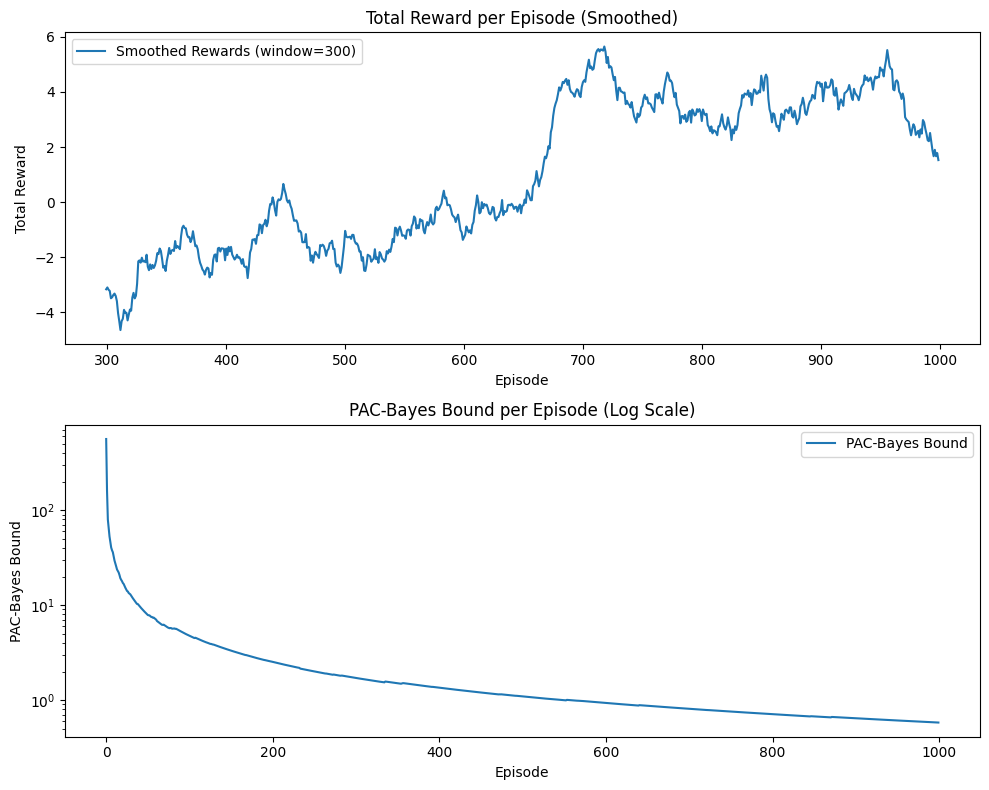

In [11]:
def moving_average(data, window_size):
    """Compute a simple moving average."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # Now 2 subplots

# Window size for moving average
window_size = 300

# Plot smoothed rewards
smoothed_rewards = moving_average(rewards, window_size)
axs[0].plot(np.arange(window_size - 1, len(rewards)), smoothed_rewards, label=f'Smoothed Rewards (window={window_size})')
axs[0].set_title("Total Reward per Episode (Smoothed)")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Total Reward")
axs[0].legend()

# Plot PAC-Bayes bounds
axs[1].plot(pac_bayes_bounds, label='PAC-Bayes Bound')
axs[1].set_yscale("log")  # Setting y-axis to logarithmic scale
axs[1].set_title("PAC-Bayes Bound per Episode (Log Scale)")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("PAC-Bayes Bound")
axs[1].legend()

plt.tight_layout()
plt.show()